In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.models.segmentation import deeplabv3_resnet101
from PIL import Image
import os
import glob
import numpy as np
import random
from einops import rearrange
import torch.nn.functional as F
from timm import create_model


/Users/connormacdonald/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/connormacdonald/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SementicSegmentationDrone(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, tile_size=512):
        self.images = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
        self.masks = sorted(glob.glob(os.path.join(mask_dir, "*.png")))
        self.transform = transform
        self.tile_size = tile_size

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        mask = Image.open(self.masks[idx])
        
        image = image.resize((self.tile_size, self.tile_size))
        mask = mask.resize((self.tile_size, self.tile_size), Image.NEAREST)

        mask = np.array(mask)

        # Your predefined RGB-to-class index mapping
        raw_to_8_class = {
            0: 0,   # unlabeled
            1: 1,   # paved-area
            2: 2,   # dirt
            3: 3,   # wall
            4: 4,   # gravel
            5: 5,   # water
            6: 6,   # rocks
            7: 7
            
        }

        def remap_mask(mask_array):
            remapped = np.zeros_like(mask_array)
            for raw_val, new_val in raw_to_8_class.items():
                remapped[mask_array == raw_val] = new_val
            return remapped

        mask = remap_mask(mask)
        if image.size[0] > self.tile_size or image.size[1] > self.tile_size:
            image_tiles, mask_tiles = self.split_into_tiles(image, mask)
            idx_tile = random.randint(0, len(image_tiles) - 1)
            image, mask = image_tiles[idx_tile], mask_tiles[idx_tile]

        if self.transform:
            image = self.transform(image)
            mask = torch.tensor(mask, dtype=torch.long)

        return image, mask
    
    def split_into_tiles(self, image, mask):
        image_width, image_height = image.size
        image_tiles = []
        mask_tiles = []

        for i in range(0, image_width, self.tile_size):
            for j in range(0, image_height, self.tile_size):
                image_tile = image.crop((i, j, min(i+self.tile_size, image_width), min(j+self.tile_size, image_height)))
                mask_pil = Image.fromarray(mask) 
                mask_tile = mask_pil.crop((i, j, min(i+self.tile_size, image_width), min(j+self.tile_size, image_height)))
                image_tiles.append(image_tile)
                mask_tiles.append(np.array(mask_tile))

        return image_tiles, mask_tiles

In [3]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=4, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x):
        attn_out, _  = self.attn(x, x, x)
        x = self.norm1(x + attn_out)
        x = self.norm2(x + self.ff(x))
        return x

In [4]:

class UperNetSwin(nn.Module):
    def __init__(self, num_classes=10):
        super(UperNetSwin, self).__init__()
        self.backbone = create_model('swin_tiny_patch4_window7_224', pretrained=True, features_only=True, img_size=512)
        self.decoder = nn.Sequential(
            nn.Conv2d(768, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_classes, kernel_size=1)
        )

    def forward(self, x):
        features = self.backbone(x)
        x = features[-1]  # Swin-T last feature
        if x.shape[1] < x.shape[-1]:  # Channel is last
            x = x.permute(0, 3, 1, 2)
        x = self.decoder(x)
        x = nn.functional.interpolate(x, scale_factor=32, mode='bilinear', align_corners=False)
        return x



In [5]:
directory = {
    "train_images": "advanced_data/x_train",
    "train_masks": "advanced_data/y_train",
    "val_images": "advanced_data/x_valid",
    "val_masks": "advanced_data/y_valid",
    "test_images": "advanced_data/x_test",
    "test_masks": "advanced_data/y_test"
}

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = SementicSegmentationDrone(directory["train_images"], directory["train_masks"], transform=transform, tile_size=512)
valid_data = SementicSegmentationDrone(directory["val_images"], directory["val_masks"], transform=transform, tile_size=512)
test_data = SementicSegmentationDrone(directory["test_images"], directory["test_masks"], transform=transform, tile_size=512)

train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=False)

In [6]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UperNetSwin(num_classes=10).to(device)

weights = torch.tensor([0.5] + [2.0] * 9).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.Adam(model.parameters(), lr=0.0005)


In [7]:
def calculate_accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == labels).float()
    return correct.sum() / correct.numel()


In [8]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
) 

In [9]:
def calculate_miou(preds, masks, num_classes):
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (masks == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))  # Ignore this class if no presence
        else:
            ious.append(intersection / union)
    return torch.tensor(ious).nanmean().item()

num_classes = 10
epochs = 15
for epoch in range(epochs):
    model.train()

    running_loss = 0.0

    for images, masks in train_dataloader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)                    
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train = running_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train:.4f}")

    model.eval()
    valid_loss = 0.0
    valid_acc = 0.0
    valid_miou = 0.0

    with torch.no_grad():
        for images, masks in valid_dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            valid_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)  # ← Needed for mIoU
            valid_acc += calculate_accuracy(outputs, masks).item()
            valid_miou += calculate_miou(preds, masks, num_classes)  

    avg_val_loss = valid_loss / len(valid_dataloader)
    avg_val_acc = valid_acc / len(valid_dataloader)
    avg_val_miou = valid_miou / len(valid_dataloader)

    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {avg_val_acc:.4f}, mIoU: {avg_val_miou:.4f}\n")
    scheduler.step(avg_val_loss)


Epoch 1/15, Train Loss: 1.1948
Validation Loss: 0.8220, Accuracy: 0.6501, mIoU: 0.2588

Epoch 2/15, Train Loss: 0.8114
Validation Loss: 0.5833, Accuracy: 0.7182, mIoU: 0.3506

Epoch 3/15, Train Loss: 0.6206
Validation Loss: 0.4382, Accuracy: 0.7709, mIoU: 0.4316

Epoch 4/15, Train Loss: 0.4683
Validation Loss: 0.4715, Accuracy: 0.7685, mIoU: 0.4489

Epoch 5/15, Train Loss: 0.5360
Validation Loss: 0.6501, Accuracy: 0.7053, mIoU: 0.3504

Epoch 6/15, Train Loss: 0.4323
Validation Loss: 0.3390, Accuracy: 0.8319, mIoU: 0.5186

Epoch 7/15, Train Loss: 0.3375
Validation Loss: 0.3517, Accuracy: 0.8024, mIoU: 0.4834

Epoch 8/15, Train Loss: 0.3137
Validation Loss: 0.2978, Accuracy: 0.8484, mIoU: 0.5806

Epoch 9/15, Train Loss: 0.3243
Validation Loss: 0.3521, Accuracy: 0.8235, mIoU: 0.5141

Epoch 10/15, Train Loss: 0.5176
Validation Loss: 0.5693, Accuracy: 0.6885, mIoU: 0.3843

Epoch 11/15, Train Loss: 0.3729
Validation Loss: 0.3192, Accuracy: 0.8044, mIoU: 0.5141

Epoch 12/15, Train Loss: 0.316

In [10]:
def calculate_accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == labels).float()
    return correct.sum() / correct.numel()

model.eval()
valid_loss = 0.0
valid_acc = 0.0

with torch.no_grad():
    for images, masks in valid_dataloader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        valid_loss += loss.item()

        acc = calculate_accuracy(outputs, masks)
        valid_acc += acc.item()

avg_val_loss = valid_loss / len(valid_dataloader)
avg_val_acc = valid_acc / len(valid_dataloader)
print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {avg_val_acc:.4f}')

Validation Loss: 0.2596, Accuracy: 0.8568


In [11]:
import pandas as pd

def load_class_color_map(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()  # Remove leading/trailing spaces from column names
    id2name = {}
    id2color = {}

    for idx, row in df.iterrows():
        id2name[idx] = row['name']
        id2color[idx] = (row['r'], row['g'], row['b'])  # Accessing columns without spaces

    return id2name, id2color

class_names, class_colors = load_class_color_map("archive-2/main_class_dict_seg.csv")

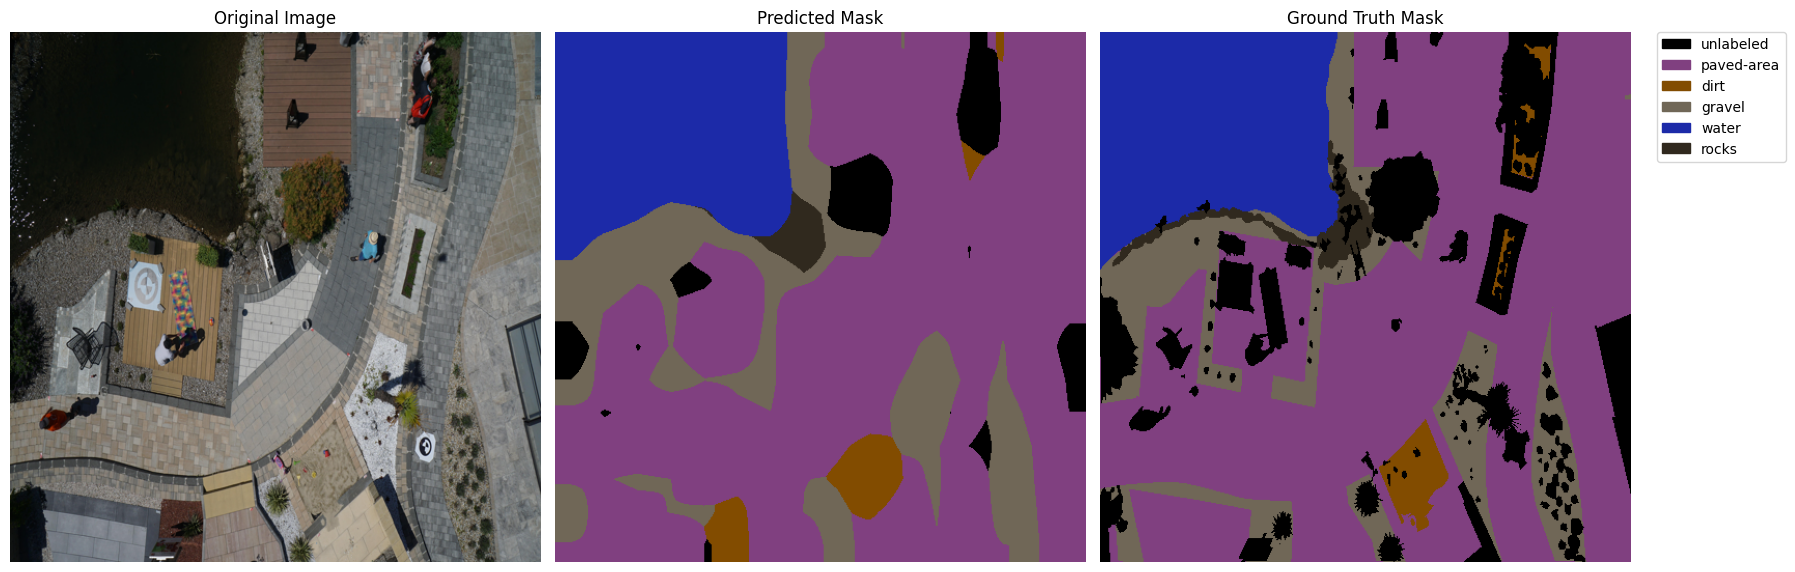

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def decode_segmentation_mask(mask, color_map):
    """Convert class-indexed mask to an RGB image."""
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in color_map.items():
        color_mask[mask == class_id] = color
    return color_mask

def visualize_pred_vs_truth(image, pred_mask, true_mask, class_names, class_colors):
    """Visualize original image, predicted mask, and true mask side-by-side."""
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()
        image = (image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # De-normalize
        image = np.clip(image * 255, 0, 255).astype(np.uint8)

    pred_color_mask = decode_segmentation_mask(pred_mask.numpy(), class_colors)
    true_color_mask = decode_segmentation_mask(true_mask.numpy(), class_colors)

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(pred_color_mask)
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(true_color_mask)
    plt.title("Ground Truth Mask")
    plt.axis("off")

    # Create legend
    unique_ids = np.unique(np.concatenate([pred_mask.numpy().flatten(), true_mask.numpy().flatten()]))
    patches = [mpatches.Patch(color=np.array(class_colors[cls]) / 255, label=class_names[cls])
               for cls in unique_ids if cls in class_names]

    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()

# Run on one test sample
model.eval()
with torch.no_grad():
    for images, masks in test_dataloader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images) # shape: (B, C, H, W)
        preds = torch.argmax(outputs, dim=1)  # shape: (B, H, W)

        # Visualize first sample in batch
        visualize_pred_vs_truth(images[0].cpu(), preds[0].cpu(), masks[0].cpu(), class_names, class_colors)
        break